In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use('ggplot')

# 데이터 구성하기

In [3]:
df = pd.read_csv('../Data/3. Big Data 분석/BOSTON_HOUSING.csv')
df

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.000000,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98
1,21.600000,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14
2,34.700001,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03
3,33.400002,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94
4,36.200001,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,22.400000,0.06263,0.0,11.93,0,0.573,6.593,69.099998,2.4786,1,273,21.000000,391.989990,9.67
502,20.600000,0.04527,0.0,11.93,0,0.573,6.120,76.699997,2.2875,1,273,21.000000,396.899994,9.08
503,23.900000,0.06076,0.0,11.93,0,0.573,6.976,91.000000,2.1675,1,273,21.000000,396.899994,5.64
504,22.000000,0.10959,0.0,11.93,0,0.573,6.794,89.300003,2.3889,1,273,21.000000,393.450012,6.48


## 결측치 확인

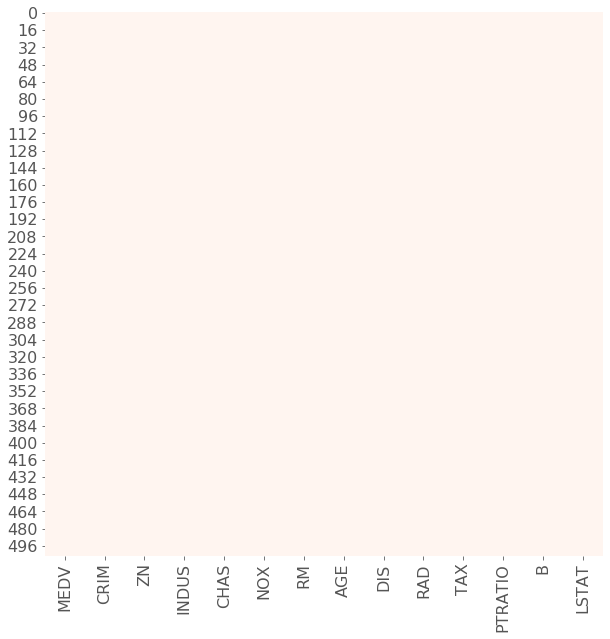

In [4]:
# 결측치 확인
plt.figure(figsize=(10,10))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')

## 이상치 확인

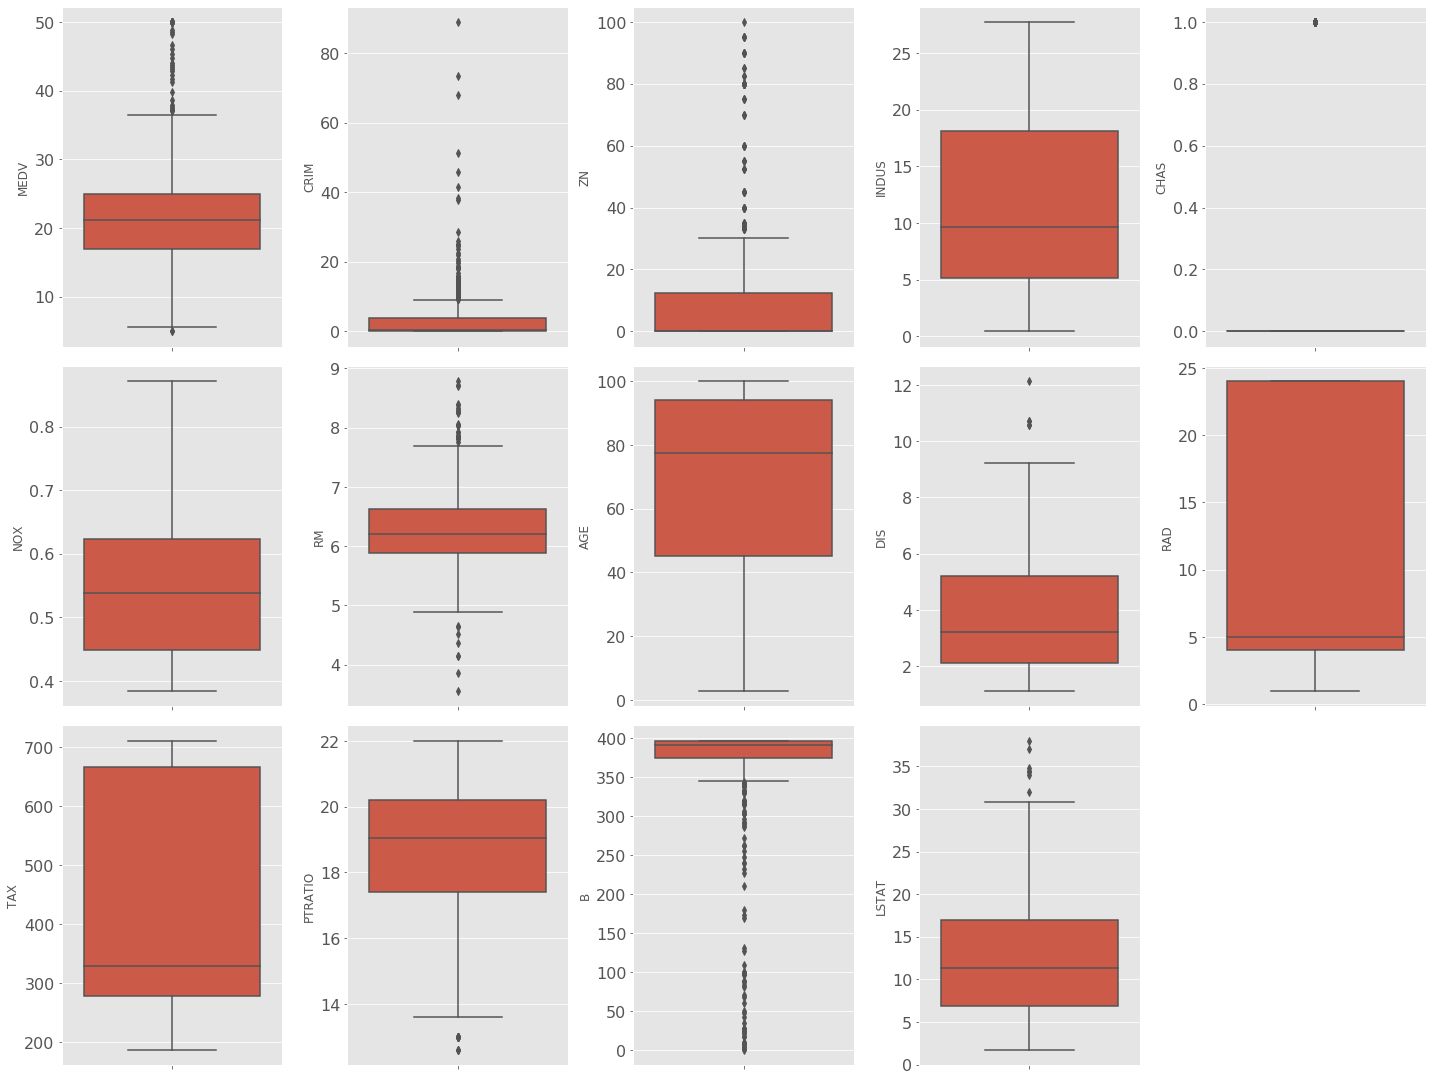

In [5]:
# 컬럼 별 box plot 시각화
plt.figure(figsize=(20,20))
for i, col in enumerate(df.columns):
    sns.boxplot(y=df[col],ax=plt.subplot(4, 5, i+1))
plt.tight_layout()

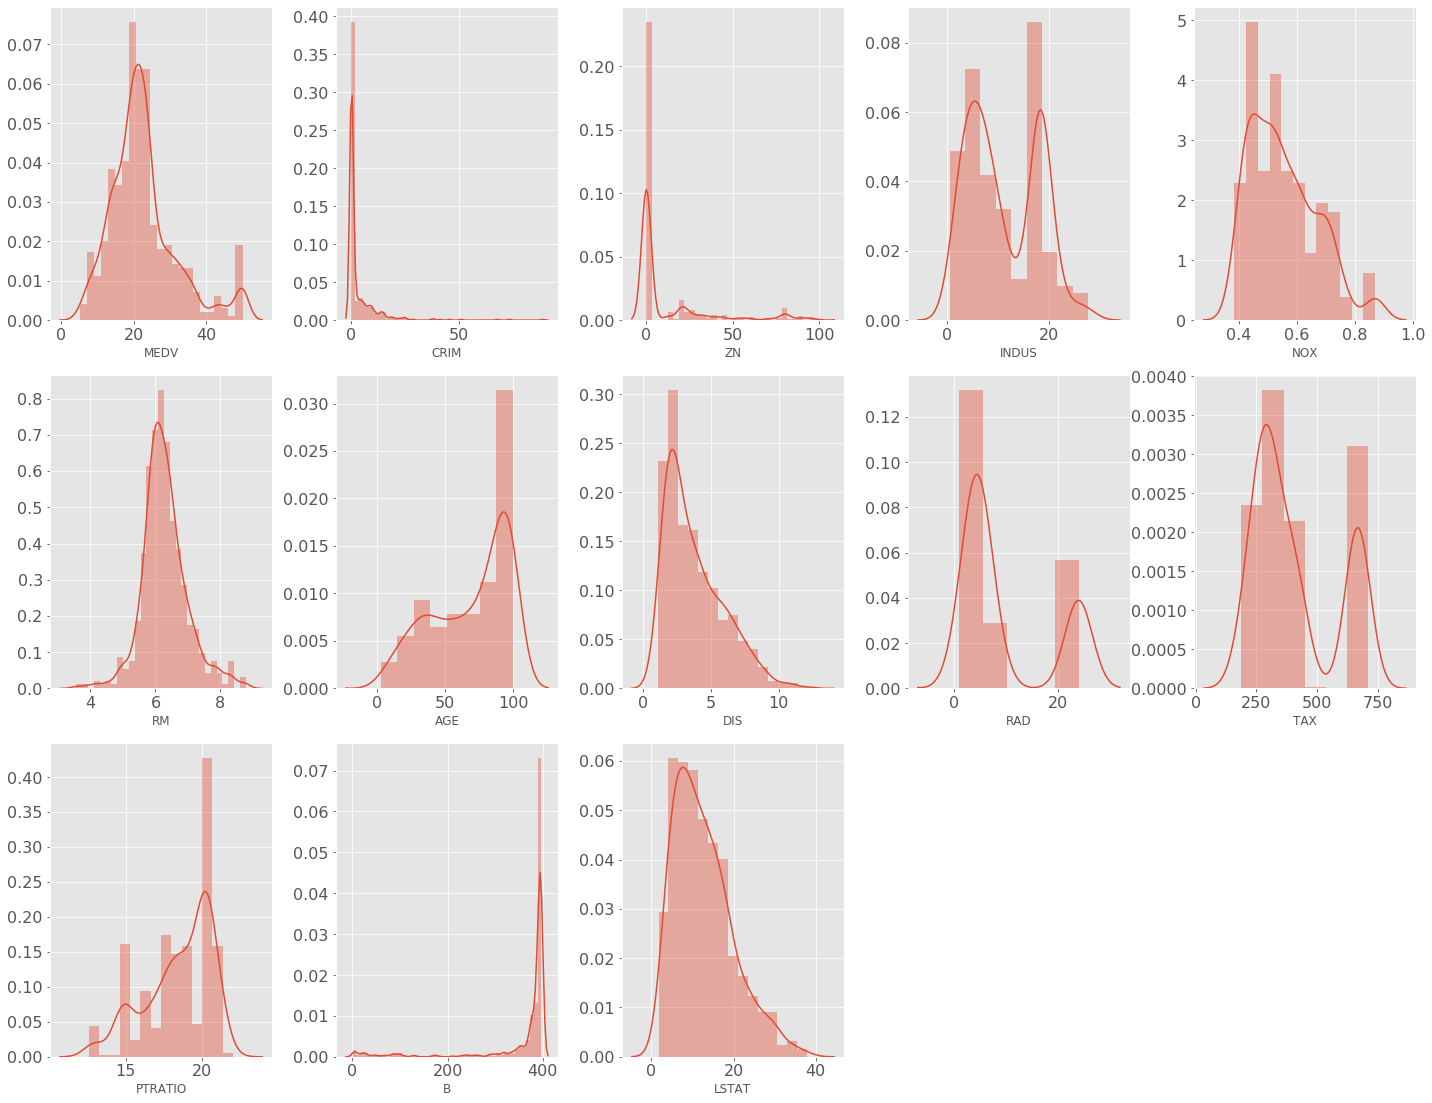

In [6]:
# 컬럼 별 box plot 시각화
plt.figure(figsize=(20,20))
for i, col in enumerate(df.columns.drop(['CHAS'])):
    sns.distplot(df[col],ax=plt.subplot(4, 5, i+1))
plt.tight_layout()

## 요약 통계량

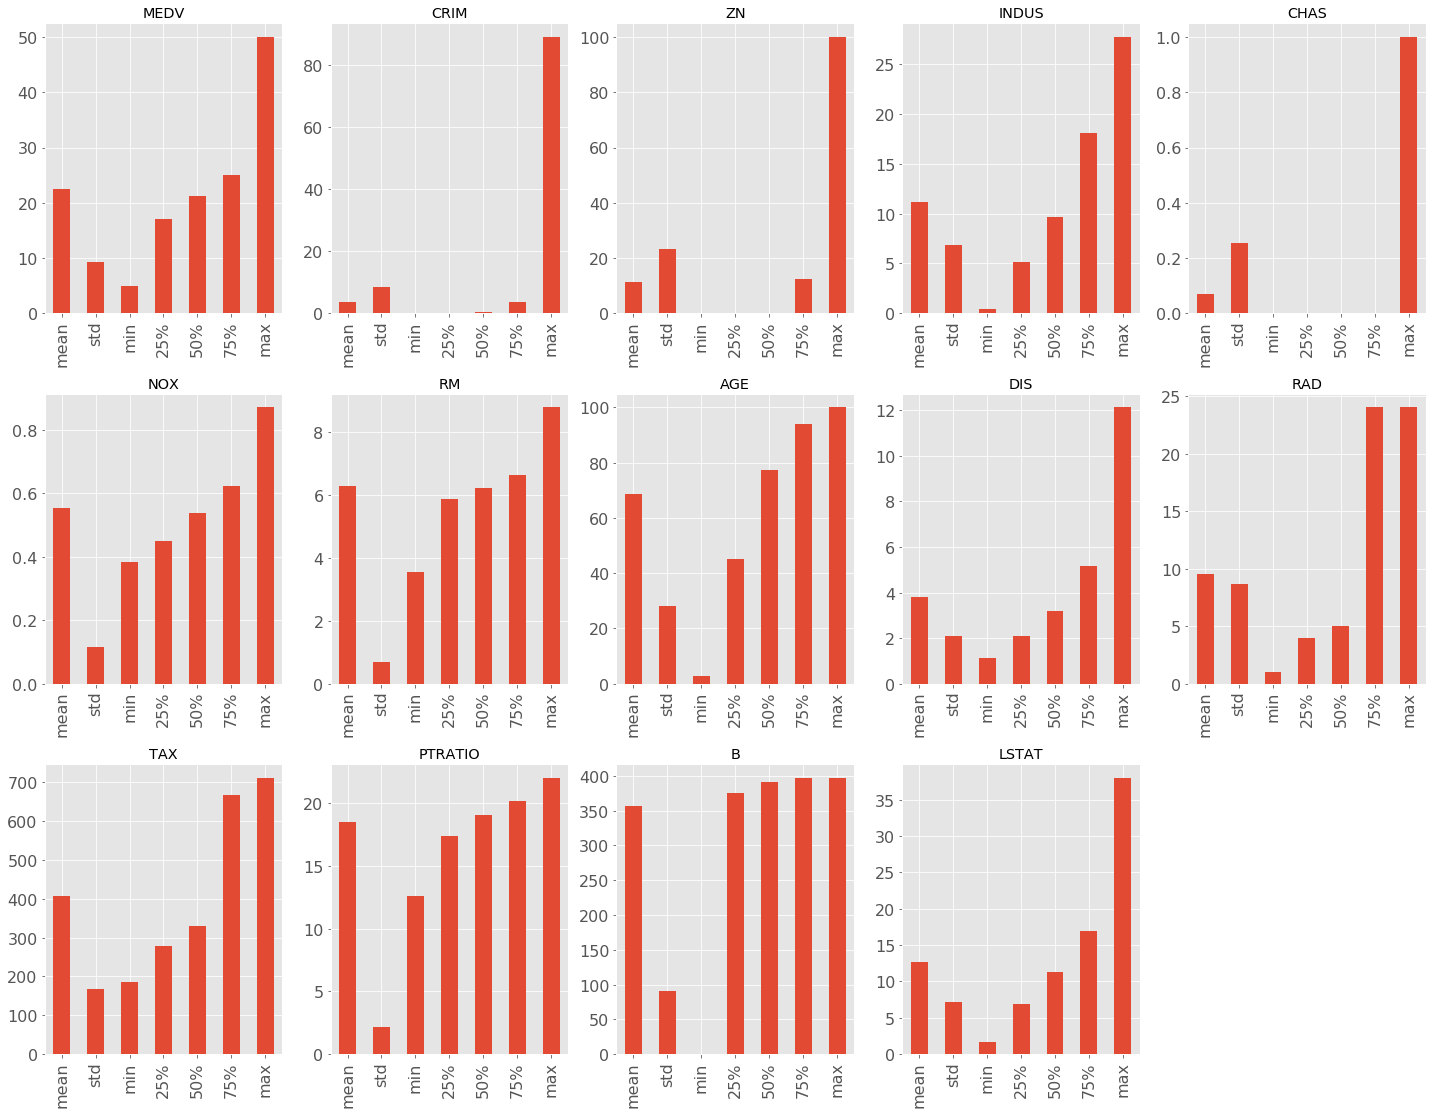

In [7]:
# 컬럼 별 요약 통계량 시각화
plt.figure(figsize=(20,20))
for i, col in enumerate(df.columns):
    df[col].describe()[1:].plot(kind='bar', title=col, ax=plt.subplot(4, 5, i+1))
plt.tight_layout()

# EDA

## 상관관계

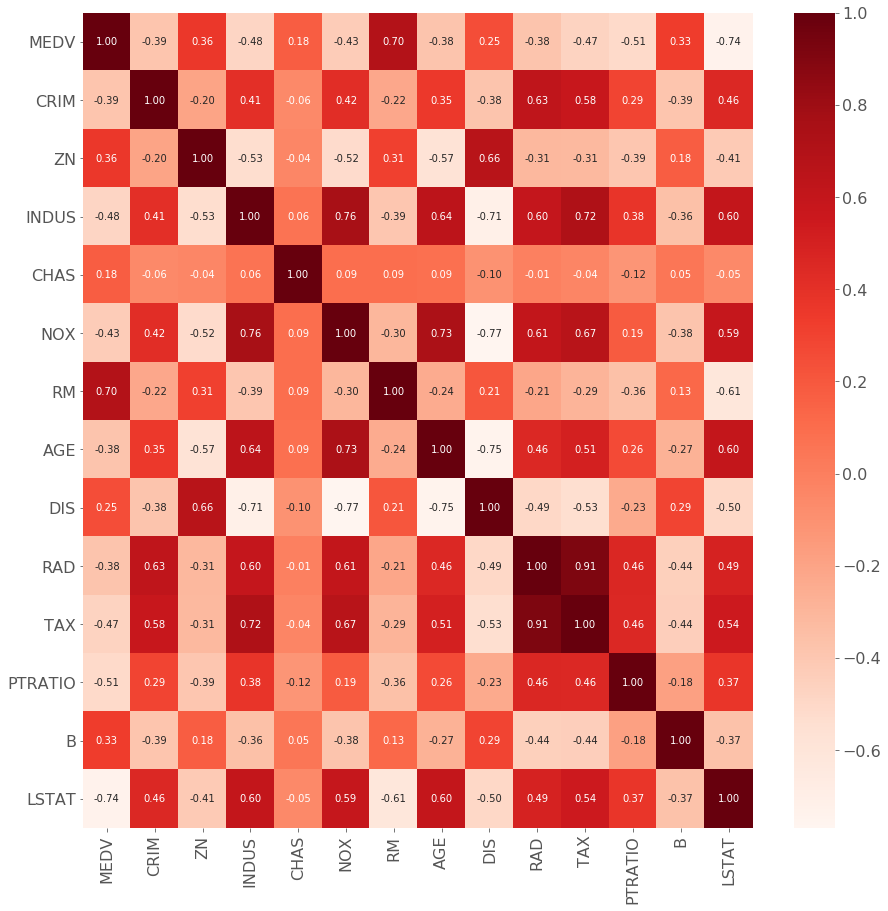

In [8]:
# 상관관계 분석
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Reds')

## 다중공선성

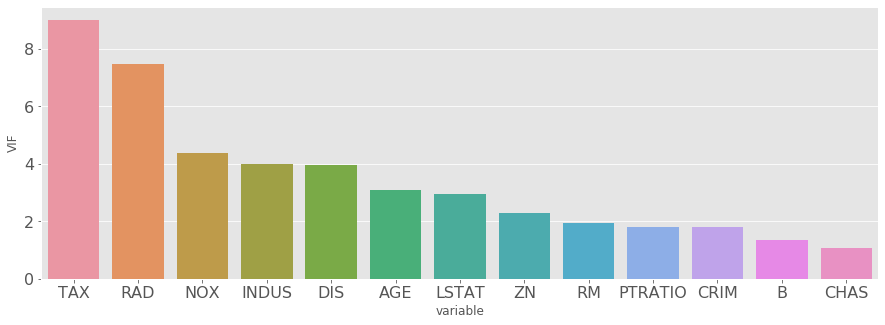

In [9]:
# 다중공선성 확인
x=df.drop("MEDV",axis=1)
x_const=sm.add_constant(x)

vif=pd.DataFrame()
vif["variable"]=x_const.columns
vif["VIF"]=[variance_inflation_factor(x_const.values, i) for i in range(x_const.shape[1])]

vif.sort_values("VIF",inplace=True, ascending=False)

plt.figure(figsize=(15,5))
ax = sns.barplot(x='variable', y='VIF', data=vif.iloc[1:])

## 2Sample t-test

In [10]:
stats.levene(df.loc[df['CHAS'] == 1, 'MEDV'], df.loc[df['CHAS'] == 0, 'MEDV'])

LeveneResult(statistic=4.590342071304883, pvalue=0.03263097878646009)

In [11]:
stats.ttest_ind(df.loc[df['CHAS'] == 1, 'MEDV'], df.loc[df['CHAS'] == 0, 'MEDV'])

Ttest_indResult(statistic=3.9964374793264246, pvalue=7.390622770250372e-05)

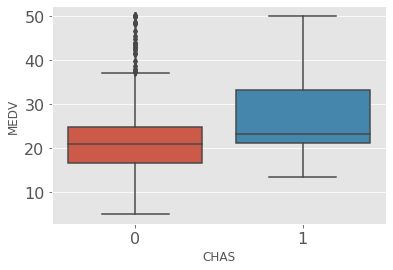

In [12]:
sns.boxplot(x='CHAS', y='MEDV', data=df)

In [13]:
stats.levene(df.loc[df['RAD'] >= 10, 'MEDV'], df.loc[df['RAD'] < 10, 'MEDV'])

LeveneResult(statistic=0.32259091409471213, pvalue=0.5703076800272064)

In [14]:
stats.ttest_ind(df.loc[df['RAD'] >= 10, 'MEDV'], df.loc[df['RAD'] < 10, 'MEDV'])

Ttest_indResult(statistic=-9.690255282930414, pvalue=1.7778936162464715e-20)

In [15]:
df['cRAD'] = np.where(df['RAD'] >= 10, 1, 0)

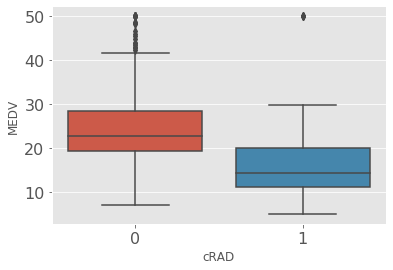

In [16]:
sns.boxplot(x='cRAD', y='MEDV', data=df)

In [17]:
stats.levene(df.loc[df['TAX'] >= 500, 'MEDV'], df.loc[df['TAX'] < 500, 'MEDV'])

LeveneResult(statistic=0.3275532709429643, pvalue=0.5673585699269548)

In [18]:
stats.ttest_ind(df.loc[df['TAX'] >= 500, 'MEDV'], df.loc[df['TAX'] < 500, 'MEDV'])

Ttest_indResult(statistic=-10.245571183482726, pvalue=1.6682534285380135e-22)

In [19]:
df['cTAX'] = np.where(df['TAX'] >= 500, 1, 0)

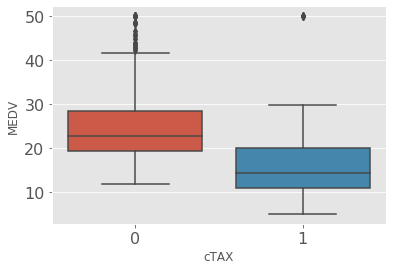

In [20]:
sns.boxplot(x='cTAX', y='MEDV', data=df)

In [21]:
stats.levene(df.loc[df['INDUS'] >= 13, 'MEDV'], df.loc[df['INDUS'] < 13, 'MEDV'])

LeveneResult(statistic=0.029257901259183147, pvalue=0.864253561728396)

In [22]:
stats.ttest_ind(df.loc[df['INDUS'] >= 13, 'MEDV'], df.loc[df['INDUS'] < 13, 'MEDV'])

Ttest_indResult(statistic=-9.814873878990936, pvalue=6.3288441524844606e-21)

In [23]:
df['cINDUS'] = np.where(df['INDUS'] >= 13, 1, 0)

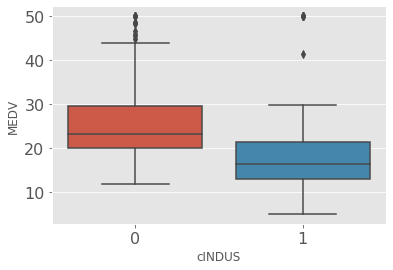

In [24]:
sns.boxplot(x='cINDUS', y='MEDV', data=df)

# EDA 분석결과

1. 다중공선성 확인 결과 10을 넘는 변수는 확인되지 않았다. -> 학습 데이터에 이상이 없으므로 별도의 전처리 없이 예측 진행
2. 상관분석 진행한 결과 LSTAT과 RM 변수가 MEDV와의 상관계수가 가장 높았다.
3. 원래 범주형이던 CHAS의 t-test를 진행한 결과 MEDV의 평균의 차이가 유의미했다.
4. 분포가 양 극단으로 나뉜 TAX, RAD, INDUS를 분포의 중간값으로 나누어 범주화하고 t-test를 진행한 결과 MEDV의 평균의 차이가 유의미했다.  
   → 이산형 범주로 새롭게 생성 후 일반 변수와의 차이를 확인할 예정

# 모델 생성

In [25]:
x_raw = df.drop(['MEDV', 'cTAX', 'cRAD', 'cINDUS'], axis=1)
x_trans = df.drop(['MEDV', 'TAX', 'RAD', 'INDUS'], axis=1)
y = df['MEDV']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_raw, y, test_size=0.3, random_state=1004)
x_trans_train, x_trans_test = train_test_split(x_trans, test_size=0.3, random_state=1004)

In [27]:
reg_model = sm.OLS(y_train, sm.add_constant(x_train))
reg_model = reg_model.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     80.62
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           2.13e-95
Time:                        21:22:40   Log-Likelihood:                -1031.3
No. Observations:                 354   AIC:                             2091.
Df Residuals:                     340   BIC:                             2145.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.7939      5.867      5.419      0.0

In [28]:
reg_model = sm.OLS(y_train, sm.add_constant(x_trans_train))
reg_model = reg_model.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     77.41
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           3.63e-93
Time:                        21:22:40   Log-Likelihood:                -1036.7
No. Observations:                 354   AIC:                             2101.
Df Residuals:                     340   BIC:                             2156.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.4445      5.981      4.923      0.0

In [29]:
# 회귀계수 p-value가 0.05 넘어가는 변수들 제거
x_const_train = sm.add_constant(x_train.drop(['INDUS', 'AGE'], axis=1))
x_trans_const_train = sm.add_constant(x_trans_train.drop(['cTAX', 'cINDUS', 'AGE', 'CRIM', 'cRAD'], axis=1))
x_const_test = sm.add_constant(x_test.drop(['INDUS', 'AGE'], axis=1))
x_trans_const_test = sm.add_constant(x_trans_test.drop(['cTAX', 'cINDUS', 'AGE', 'CRIM', 'cRAD'], axis=1))

## baseline model

In [30]:
# 모델을 생성한다.
reg_model = sm.OLS(y_train, x_const_train)
reg_trans_model = sm.OLS(y_train, x_trans_const_train)
dt = DecisionTreeRegressor(random_state=1004)
gbr = GradientBoostingRegressor(random_state=1004)
rfr = RandomForestRegressor(random_state=1004)

## raw data scoring

In [31]:
# 모델을 학습한다.
reg_model = reg_model.fit()
dt.fit(x_train, y_train)
gbr.fit(x_train, y_train)
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1004, verbose=0, warm_start=False)

In [32]:
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     95.18
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           5.35e-97
Time:                        21:22:41   Log-Likelihood:                -1032.2
No. Observations:                 354   AIC:                             2088.
Df Residuals:                     342   BIC:                             2135.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.7971      5.786      5.668      0.0

In [33]:
linear_raw_train_score = r2_score(y_train, reg_model.predict(x_const_train)).round(3)
dt_raw_train_score = r2_score(y_train, dt.predict(x_train)).round(3)
gbr_raw_train_score = r2_score(y_train, gbr.predict(x_train)).round(3)
rfr_raw_train_score = r2_score(y_train, rfr.predict(x_train)).round(3)

In [34]:
linear_raw_test_score = r2_score(y_test, reg_model.predict(x_const_test)).round(3)
dt_raw_test_score = r2_score(y_test, dt.predict(x_test)).round(3)
gbr_raw_test_score = r2_score(y_test, gbr.predict(x_test)).round(3)
rfr_raw_test_score = r2_score(y_test, rfr.predict(x_test)).round(3)

## transform data scoring

In [35]:
# 모델을 학습한다.
reg_trans_model = reg_trans_model.fit()
dt.fit(x_trans_train, y_train)
gbr.fit(x_trans_train, y_train)
rfr.fit(x_trans_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1004, verbose=0, warm_start=False)

In [36]:
print(reg_trans_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     124.5
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           7.26e-97
Time:                        21:22:42   Log-Likelihood:                -1040.0
No. Observations:                 354   AIC:                             2098.
Df Residuals:                     345   BIC:                             2133.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.6267      5.522      4.822      0.0

In [37]:
linear_trans_train_score = r2_score(y_train, reg_trans_model.predict(x_trans_const_train)).round(3)
dt_trans_train_score = r2_score(y_train, dt.predict(x_trans_train)).round(3)
gbr_trans_train_score = r2_score(y_train, gbr.predict(x_trans_train)).round(3)
rfr_trans_train_score = r2_score(y_train, rfr.predict(x_trans_train)).round(3)

In [38]:
linear_trans_test_score = r2_score(y_test, reg_trans_model.predict(x_trans_const_test)).round(3)
dt_trans_test_score = r2_score(y_test, dt.predict(x_trans_test)).round(3)
gbr_trans_test_score = r2_score(y_test, gbr.predict(x_trans_test)).round(3)
rfr_trans_test_score = r2_score(y_test, rfr.predict(x_trans_test)).round(3)

In [39]:
score_df = pd.DataFrame({'raw_test':[linear_raw_test_score, dt_raw_test_score, gbr_raw_test_score, rfr_raw_test_score],
                         'trans_test':[linear_trans_test_score, dt_trans_test_score, gbr_trans_test_score, rfr_trans_test_score],
                         'raw_train':[linear_raw_train_score, dt_raw_train_score, gbr_raw_train_score, rfr_raw_train_score], 
                         'trans_train':[linear_trans_train_score, dt_trans_train_score, gbr_trans_train_score, rfr_trans_train_score]},
                          index=['LinearRegression', 'DecisionTree', 'GradientBoosting', 'RandomForest'])

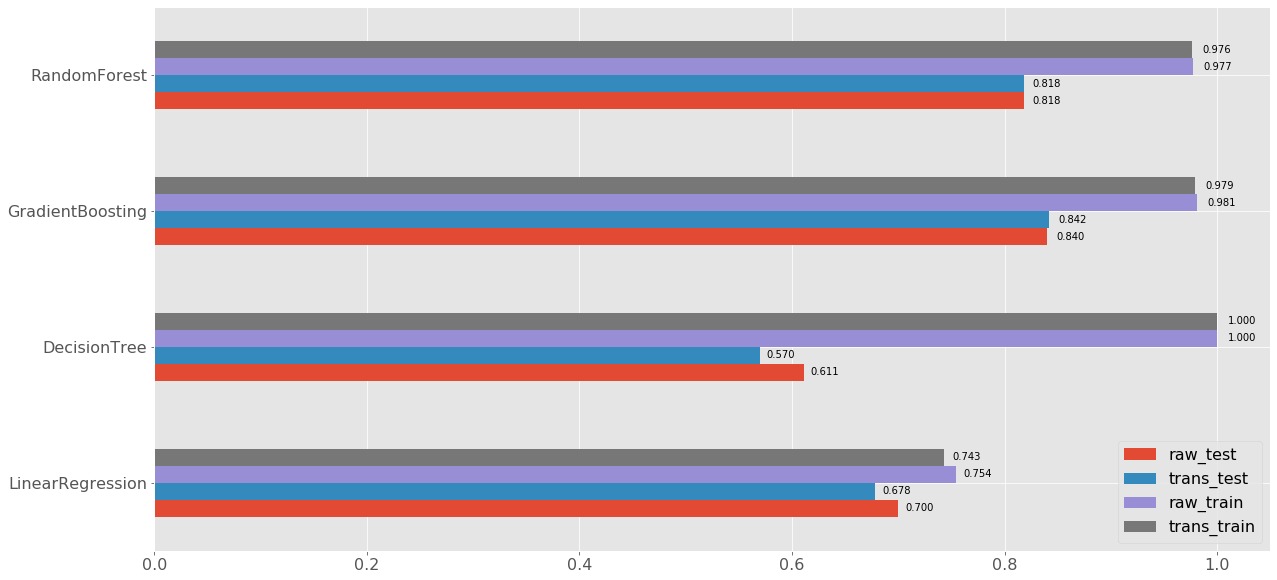

In [40]:
ax = score_df.plot(kind='barh', figsize=(20,10))

for p in ax.patches: 
    x, y, width, height = p.get_bbox().bounds 
    ax.text(width*1.01, y+height/2, "%.3f"%(width), va='center')

1. 앙상블 기법을 활용한 RandomForest 모델과 GradientBoosting 모델의 성능이 좋았다.
2. TAX, RAD, INDUS를 범주화한 trans data와 raw data의 성능 차이는 크지 않았다.

# 모델 개선

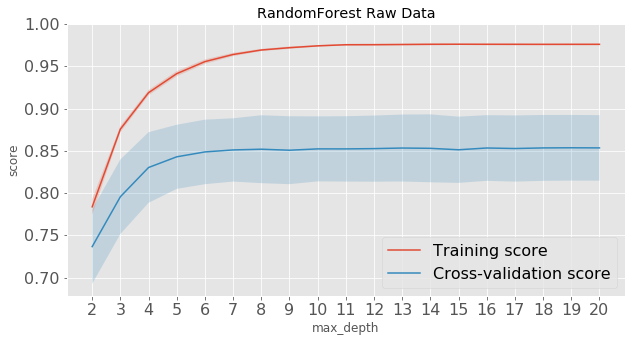

In [41]:
train_scores, test_scores = validation_curve(rfr, x_train, y_train, param_name='max_depth', param_range=[i for i in range(2,21)])

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 5),)
plt.plot([i for i in range(2,21)], train_scores_mean, label="Training score")
plt.fill_between([i for i in range(2,21)], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot([i for i in range(2,21)], test_scores_mean, label="Cross-validation score")
plt.fill_between([i for i in range(2,21)], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.ylabel('score')
plt.yticks([i / 100 for i in range(70, 101, 5)])
plt.xlabel('max_depth')
plt.xticks([i for i in range(2,21)])

plt.legend(loc="best")
plt.title('RandomForest Raw Data')
plt.show()

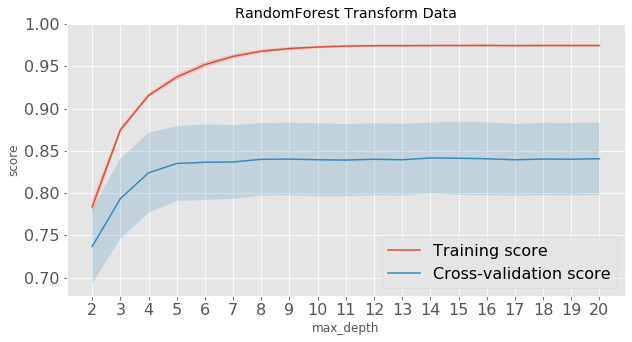

In [42]:
train_scores, test_scores = validation_curve(rfr, x_trans_train, y_train, param_name='max_depth', param_range=[i for i in range(2,21)])

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 5))
plt.plot([i for i in range(2,21)], train_scores_mean, label="Training score")
plt.fill_between([i for i in range(2,21)], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot([i for i in range(2,21)], test_scores_mean, label="Cross-validation score")
plt.fill_between([i for i in range(2,21)], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.ylabel('score')
plt.yticks([i / 100 for i in range(70, 101, 5)])
plt.xlabel('max_depth')
plt.xticks([i for i in range(2,21)])

plt.legend(loc="best")
plt.title('RandomForest Transform Data')
plt.show()

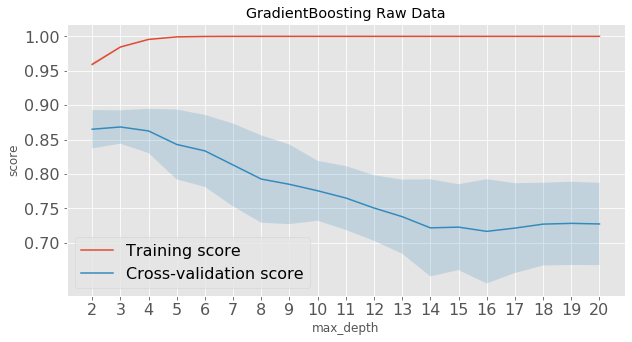

In [43]:
train_scores, test_scores = validation_curve(gbr, x_train, y_train, param_name='max_depth', param_range=[i for i in range(2,21)])

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 5))
plt.plot([i for i in range(2,21)], train_scores_mean, label="Training score")
plt.fill_between([i for i in range(2,21)], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot([i for i in range(2,21)], test_scores_mean, label="Cross-validation score")
plt.fill_between([i for i in range(2,21)], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.ylabel('score')
plt.yticks([i / 100 for i in range(70, 101, 5)])
plt.xlabel('max_depth')
plt.xticks([i for i in range(2,21)])

plt.legend(loc="best")
plt.title('GradientBoosting Raw Data')
plt.show()

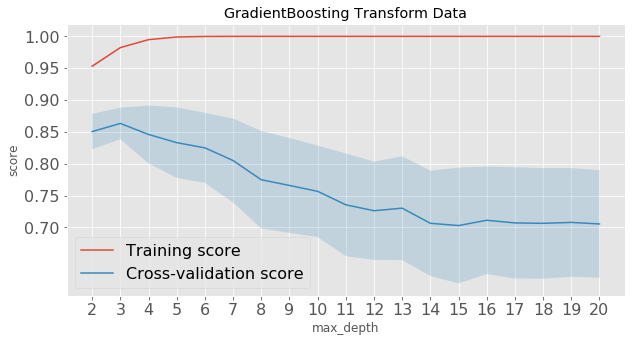

In [44]:
train_scores, test_scores = validation_curve(gbr, x_trans_train, y_train, param_name='max_depth', param_range=[i for i in range(2,21)])

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 5))
plt.plot([i for i in range(2,21)], train_scores_mean, label="Training score")
plt.fill_between([i for i in range(2,21)], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot([i for i in range(2,21)], test_scores_mean, label="Cross-validation score")
plt.fill_between([i for i in range(2,21)], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.ylabel('score')
plt.yticks([i / 100 for i in range(70, 101, 5)])
plt.xlabel('max_depth')
plt.xticks([i for i in range(2,21)])

plt.legend(loc="best")
plt.title('GradientBoosting Transform Data')
plt.show()

# 최종 평가

In [45]:
rfr_final = RandomForestRegressor(max_depth=13, random_state=1004)

In [46]:
rfr_final.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=13, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1004, verbose=0, warm_start=False)

In [47]:
final_raw_train_score = r2_score(y_train, rfr_final.predict(x_train)).round(3)
final_raw_test_score = r2_score(y_test, rfr_final.predict(x_test)).round(3)

In [48]:
rfr_final.fit(x_trans_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=13, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1004, verbose=0, warm_start=False)

In [49]:
final_trans_train_score = r2_score(y_train, rfr_final.predict(x_trans_train)).round(3)
final_trans_test_score = r2_score(y_test, rfr_final.predict(x_trans_test)).round(3)

In [50]:
score_df = pd.DataFrame({'r2_score':[final_raw_test_score, final_trans_test_score, final_raw_train_score, final_trans_train_score]}, 
                        index=['raw_test', 'trans_test', 'raw_train', 'trans_train'])

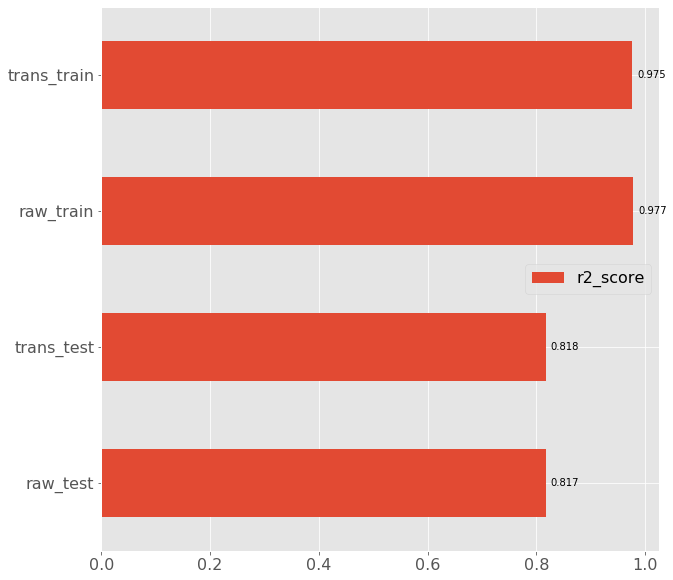

In [51]:
ax = score_df.plot(kind='barh', figsize=(10,10))

for p in ax.patches: 
    x, y, width, height = p.get_bbox().bounds 
    ax.text(width*1.01, y+height/2, "%.3f"%(width), va='center')

Text(0, 0.5, 'Feature')

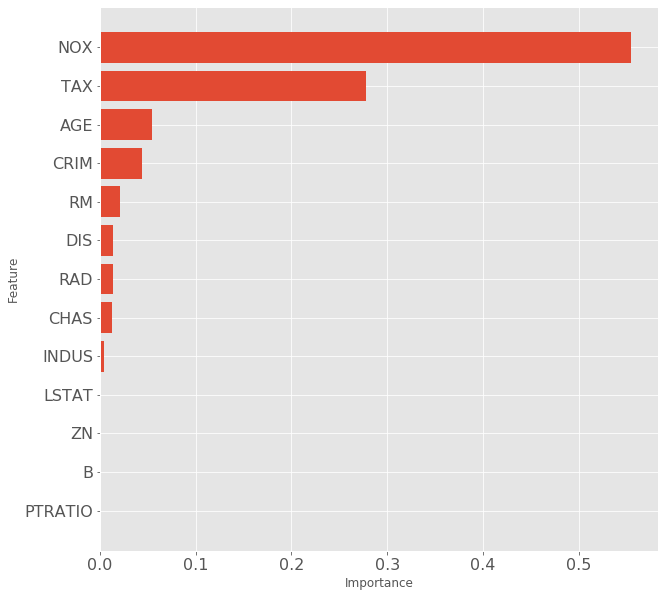

In [52]:
v_feature_name = x_train.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rfr_final.feature_importances_
df_importance.sort_values('Importance', ascending=True, inplace=True)

coordinates = range(len(df_importance))
plt.figure(figsize=(10,10))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')